In [1]:
# model class 

import torch 
from torch import nn 
from tqdm.auto import tqdm 

import json
from importlib import reload

import torch
import numpy as np
import pandas as pd 
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score


class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, nclasses, class_weigths=None, device='cpu') -> None:
        super().__init__()

        # self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim).to(device)
        self.lstm_model = nn.LSTM(embedding_dim, hidden_size//2, bidirectional=True).to(device)
        self.ffwd_lay = nn.Linear(hidden_size, nclasses).to(device)
        self.softmax = nn.Softmax(dim=1).to(device)

        self.optim = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.criterion = nn.CrossEntropyLoss(weight=class_weigths)
        
        self.loss_history = []


    def forward(self, batch):
        # out = self.embedding(batch) # L x vocab_size -> L x embedding_dim
        out = self.lstm_model(batch)[0] # L x hidden_size
        out = self.ffwd_lay(out) # L x nclasses
        return self.softmax(out)


    def fit(self, train_X, train_Y, valid_X, valid_Y, nepochs, lr, device):
        self.train()
        self.to(device)

        for g in self.optim.param_groups:
            g['lr'] = lr    
        
        for ep in tqdm(range(nepochs)):
            eploss = 0

            for batch_X, batch_Y in zip(train_X, train_Y):
                predict = self.forward(batch_X.to(device))
                
                self.optim.zero_grad()
                loss = self.criterion(predict, batch_Y.to(device))
                loss.backward()
                self.optim.step()

                eploss += loss.item()
                self.loss_history.append(loss.item())
            
            printbool = ep % (nepochs//10) == 0 if nepochs > 10 else True
            if printbool:
                with torch.no_grad():
                    train_predict = []
                    for batch_X in train_X:
                        predict = torch.argmax(self.forward(batch_X.to(device)), dim=1)
                        train_predict.append(predict.cpu())
                    
                    train_predict = torch.cat(train_predict)
                    train_real = torch.cat(train_Y)
    
                    test_predict = []
                    for batch_X in valid_X:
                        predict = torch.argmax(self.forward(batch_X.to(device)), dim=1)
                        test_predict.append(predict.cpu())
                    
                    test_predict = torch.cat(test_predict)
                    test_real = torch.cat(valid_Y)

                    # train_predict, train_real = train_predict[train_predict != 0], train_real[train_predict != 0]
                    # test_predict, test_real = test_predict[test_predict != 0], test_real[test_predict != 0]
                    TP = ((train_predict == train_real) & (train_predict != 0)).sum()
                    FP = ((train_predict != train_real) & (train_predict != 0)).sum()
                    acc_metric_train = TP / (TP + FP)

                    TP = ((test_predict == test_real) & (test_predict != 0)).sum()
                    FP = ((test_predict != test_real) & (test_predict != 0)).sum()
                    acc_metric_valid = TP / (TP + FP)
                    
                    print(f'Iter: {ep}, Loss: {eploss/len(train_X):.3f} Train precision {acc_metric_train:.3f}:, Valid precision: {acc_metric_valid:.3f}')
                    # print(f'Iter: {ep}, Loss: {eploss/len(train_X):.3f} Train BA: {balanced_accuracy_score(train_real, train_predict):.3f}, Train F1: {f1_score(train_real, train_predict, average="micro"):.3f}, Valid BA: {balanced_accuracy_score(test_real, test_predict):.3f}, Valid F1: {f1_score(test_real, test_predict, average="micro"):.3f}')
                        
            # printbool = ep % (nepochs//10) == 0 if nepochs > 10 else True
            # if printbool:
            #     print(f'Train loss: {eploss/len(train_X):.3f}')

In [2]:
def data_label_split(data, label, train_size=0.8):
    randidx = np.arange(len(data))
    data_train, data_test = train_test_split(data, randidx, train_size)
    label_train, label_test = train_test_split(label, randidx, train_size)

    return data_train, data_test, label_train, label_test

def train_test_split(data, randidx, train_size):
    N = len(data)
    return [data[i] for i in randidx[:int(train_size*N)]], [data[i] for i in randidx[int(train_size*N):]]

def shuffle_data_label_lists(data, label):
    randidx = np.arange(len(data))
    np.random.shuffle(randidx)
    return [data[i] for i in randidx], [label[i] for i in randidx]

def embedding(data, token2emb):
    tokens_lst = []
    labels_lst = []
    for doc in tqdm(data):
        tokens = map(lambda x: x.replace('\t', '').replace('\n', '').replace(' ', ''), doc['tokens'])
        emb_tokens = []
        for token in tokens:
            if token in token2emb:
                emb_tokens.append(token2emb[token])
            else:
                emb_tokens.append([token2emb[it] if it in token2emb else [0]*300 for it in list(token)])
        tokens_lst.append(torch.FloatTensor(emb_tokens))
        labels_lst.append(torch.LongTensor([label2num[it] if it in label2num else 0 for it in doc['labels']]))
    return tokens_lst, labels_lst

def batch_split(X, Y, seq_len, batch_size=1000):
    x_batched = []
    y_batched = []
    seq_len_batched = []

    n = len(X)
    pointer = 0
    while pointer + batch_size < n:
        x_batched.append(X[pointer:pointer+batch_size])
        y_batched.append(Y[pointer:pointer+batch_size])
        seq_len_batched.append(seq_len[pointer:pointer+batch_size])
        pointer += batch_size 
    
    x_batched.append(X[pointer:])
    y_batched.append(Y[pointer:])
    seq_len_batched.append(seq_len[pointer:])

    return x_batched, y_batched, seq_len_batched


label2num = {
    'B-NAME_STUDENT': 0, 
    'I-NAME_STUDENT': 0, 
    'B-STREET_ADDRESS': 0, 
    'I-STREET_ADDRESS': 0, 
    'B-USERNAME': 1,
    'I-USERNAME': 1, 
    'B-ID_NUM': 2, 
    'I-ID_NUM': 2, 
    
    'O': 0,
    'B-URL_PERSONAL': 0, 
    'I-URL_PERSONAL': 0, 
    'B-EMAIL': 0, 
    'I-EMAIL': 0,
    'B-PHONE_NUM': 0, 
    'I-PHONE_NUM': 0, 
}

num2label = {
    0: 'O',
    1: 'USERNAME',
    2: 'ID_NUM',
    # 1: 'NAME_STUDENT', 
    # 1: 'STREET_ADDRESS', 
}

In [3]:
# load fastext
token2emb = {}
with open('wiki-news-300d-1M.vec', 'r', encoding='utf-8') as f:
    next(f)
    for it in tqdm(f):
        row = it.split(' ')
        token2emb[row[0]] = list(map(float, row[1:]))

0it [00:00, ?it/s]

In [4]:
# encoding tokens and labels
with open('data/mixtral-8x7b-v1.json', 'r', encoding='utf-8') as f:
    data_1 = json.load(f)
with open('data/train.json', 'r', encoding='utf-8') as f:
    data_2 = json.load(f)
data = data_1 + data_2

# shuffle data
randidx = np.arange(len(data))
np.random.shuffle(randidx)
data = [data[i] for i in randidx]

# split data on train and valid
train_data, valid_data = data[:7000], data[7000:]
train_tokens, train_labels = embedding(train_data, token2emb)
valid_tokens, valid_labels = embedding(valid_data, token2emb)

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/2162 [00:00<?, ?it/s]

In [6]:
token2emb = None
import gc
gc.collect()

534

In [7]:
# init class weigths
class_weigths = torch.zeros(max(label2num.values())+1)
for i in range(len(class_weigths)):
    class_weigths[i] = sum([(it == i).sum().item() for it in train_labels])
class_weigths = 1 / class_weigths 
class_weigths /= class_weigths.sum()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# fit lstm
model = BiLSTM(
    embedding_dim=300,
    hidden_size=32,
    nclasses=len(class_weigths),
    device=device,
    class_weigths=class_weigths
)

In [9]:
model.fit(
    train_X=train_tokens,
    train_Y=train_labels,
    valid_X=valid_tokens,
    valid_Y=valid_labels,
    nepochs=100,
    lr=1e-3,
    device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

Iter: 0, Loss: 0.576 Train precision 0.090:, Valid precision: 0.094
Iter: 10, Loss: 0.554 Train precision 0.392:, Valid precision: 0.386
Iter: 20, Loss: 0.554 Train precision 0.436:, Valid precision: 0.428
Iter: 30, Loss: 0.554 Train precision 0.467:, Valid precision: 0.449
Iter: 40, Loss: 0.554 Train precision 0.472:, Valid precision: 0.454
Iter: 50, Loss: 0.553 Train precision 0.495:, Valid precision: 0.474
Iter: 60, Loss: 0.553 Train precision 0.495:, Valid precision: 0.468
Iter: 70, Loss: 0.553 Train precision 0.500:, Valid precision: 0.475
Iter: 80, Loss: 0.553 Train precision 0.509:, Valid precision: 0.481
Iter: 90, Loss: 0.553 Train precision 0.505:, Valid precision: 0.474


In [10]:
model.fit(
    train_X=train_tokens,
    train_Y=train_labels,
    valid_X=valid_tokens,
    valid_Y=valid_labels,
    nepochs=50,
    lr=1e-4,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

Iter: 0, Loss: 0.553 Train precision 0.519:, Valid precision: 0.490
Iter: 5, Loss: 0.553 Train precision 0.525:, Valid precision: 0.494
Iter: 10, Loss: 0.553 Train precision 0.529:, Valid precision: 0.496
Iter: 15, Loss: 0.553 Train precision 0.532:, Valid precision: 0.498
Iter: 20, Loss: 0.553 Train precision 0.535:, Valid precision: 0.500
Iter: 25, Loss: 0.553 Train precision 0.538:, Valid precision: 0.503
Iter: 30, Loss: 0.553 Train precision 0.542:, Valid precision: 0.505
Iter: 35, Loss: 0.553 Train precision 0.544:, Valid precision: 0.505
Iter: 40, Loss: 0.553 Train precision 0.546:, Valid precision: 0.508
Iter: 45, Loss: 0.553 Train precision 0.549:, Valid precision: 0.510


In [12]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optim.state_dict(),
    }, 'saved_models/bi_lstm2.pt')

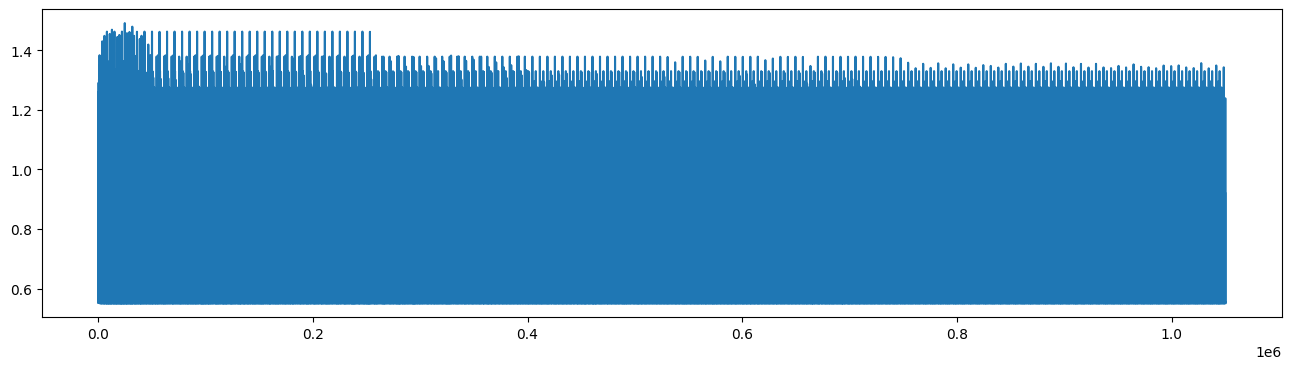

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(model.loss_history)

In [17]:
with torch.no_grad():
    train_predict = []
    train_proba = []
    for batch_X in train_tokens:
        predict = model(batch_X.to(device)).cpu()
        train_proba.append(predict[:, 1])
        train_predict.append(torch.argmax(predict, dim=1))
    
    train_predict = torch.cat(train_predict)
    train_proba = torch.cat(train_proba)
    train_real = torch.cat(train_labels)

    print(f'BA: {balanced_accuracy_score(train_real, train_predict):.3f}')
    print(f'F1: {f1_score(train_real, train_predict, average="micro"):.3f}')
    # print(f'ROC AUC: {roc_auc_score(train_real, train_proba):.3f}')

BA: 0.995
F1: 0.999


In [18]:
with torch.no_grad():
    valid_predict = []
    valid_proba = []
    for batch_X in valid_tokens:
        predict = model(batch_X.to(device)).cpu()
        valid_proba.append(predict[:, 1])
        valid_predict.append(torch.argmax(predict, dim=1))

    valid_predict = torch.cat(valid_predict)
    valid_proba = torch.cat(valid_proba)
    valid_real = torch.cat(valid_labels)

    print(f'BA: {balanced_accuracy_score(valid_real, valid_predict):.3f}')
    print(f'F1: {f1_score(valid_real, valid_predict, average="micro"):.3f}')
    # print(f'ROC AUC: {roc_auc_score(test_real, test_proba):.3f}')

BA: 0.958
F1: 0.999


In [25]:
columns = [
    'O',
    'STREET_ADDRESS',
    'USERNAME',
    'ID_NUM',
    # 'NAME_STUDENT',
]

pd.DataFrame(confusion_matrix(test_real, test_predict), columns=columns)

,O,STREET_ADDRESS,USERNAME,ID_NUM
0,1657550,0,0,0
1,7,5185,0,0
2,547,0,0,0
3,840,1,0,0


In [ ]:
test_real == ''

In [19]:
token2emb = []
train_tokens = []
train_labels = []
test_tokens = []
test_labels = []

gc.collect()

270

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class_weigths = torch.FloatTensor([1,1,1])
model = BiLSTM(
    embedding_dim=300,
    hidden_size=32,
    nclasses=len(class_weigths),
    device=device,
    class_weigths=class_weigths
)

checkpoint = torch.load('saved_models/bi_lstm2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.optim.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
model.to(device)
print()

In [5]:
token2emb = {}
with open('wiki-news-300d-1M.vec', 'r', encoding='utf-8') as f:
    next(f)
    for it in tqdm(f):
        row = it.split(' ')
        token2emb[row[0]] = list(map(float, row[1:]))


0it [00:00, ?it/s]

In [25]:
def get_predict_table(data):
    def check_name(x):
        flag = False
        flag = x[0].isupper()
        for it in x[1:]:
            flag *= it.islower()
        return flag

    predict_table = [[], [], [], [], []] # document, token_idx, token, predict, real
    for doc in tqdm(data):
        with torch.no_grad():
            doc_tokens = torch.FloatTensor([token2emb[it] if it in token2emb else [0]*300 for it in doc['tokens']])
            predict = torch.argmax(model.forward(doc_tokens.to(device)), dim=1).cpu()
            predict = [num2label[it.item()] for it in predict]
            predict = ['O' if len(set(x)) < 2 else y for x, y in zip(doc['tokens'], predict)]
            predict_table[0] += [doc['document']]*len(predict)
            predict_table[1] += list(range(len(predict)))
            predict_table[2] += doc['tokens']
            predict_table[3] += predict
            predict_table[4] += doc['labels'] 
        
    predict_table = [[predict_table[0][i], predict_table[1][i], predict_table[2][i], predict_table[3][i], predict_table[4][i]] for i in range(len(predict_table[0]))]
    predict_table = pd.DataFrame(predict_table, columns=['document', 'token_i', 'token', 'predict', 'label'])
    predict_table = predict_table.loc[((predict_table.predict != 'O') | (predict_table.label != 'O')) & ((predict_table.token != "\n") | (predict_table.token != "\n\n") | (predict_table.token != "\t"))].reset_index(drop=True)
    predict_table['prefix'] = 'B-'

    predict_table['upper_start'] = predict_table.token.apply(check_name)
    predict_table = predict_table.loc[((predict_table.upper_start == 1) & (predict_table.predict == 'NAME_STUDENT')) | (predict_table.predict != 'NAME_STUDENT')].reset_index(drop=True)
    predict_table = predict_table.sort_values('document').reset_index(drop=True)

    return predict_table.loc[predict_table.label.isin(set(['O', 'B-ID_NUM', 'I-ID_NUM', 'B-USERNAME', 'I-USERNAME']))].reset_index(drop=True)

In [26]:
num2label = {
    0: 'O',
    1: 'USERNAME',
    2: 'ID_NUM',
    # 1: 'NAME_STUDENT', 
    # 1: 'STREET_ADDRESS', 
}

In [36]:
import gc
with open('data/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
predict_table = get_predict_table(data)
gc.collect()

for i in range(1, predict_table.shape[0]):
    if (predict_table.at[i-1, 'predict'] == predict_table.at[i, 'predict']) & (predict_table.at[i-1, 'document'] == predict_table.at[i, 'document']) & (predict_table.at[i, 'token_i'] - predict_table.at[i-1, 'token_i'] == 1):
        predict_table.at[i, 'prefix'] = 'I-'
predict_table['predict'] = predict_table['prefix'] + predict_table['predict']

print(f'F1 score: {f1_score(predict_table.label, predict_table.predict, average="micro")}')

  0%|          | 0/6807 [00:00<?, ?it/s]

0

In [39]:
print(f'F1 score: {f1_score(predict_table.label, predict_table.predict, average="micro")}')

F1 score: 0.7912087912087912


In [40]:
predict_table.loc[predict_table.predict != predict_table.label].groupby('predict', as_index=False).label.count()

,predict,label
0,B-ID_NUM,6
1,B-O,10
2,B-USERNAME,3


In [41]:
predict_table.loc[predict_table.predict != predict_table.label]

,document,token_i,token,predict,label,prefix,upper_start
3,609,68,557349702179,B-USERNAME,B-ID_NUM,B-,0
10,3351,61,castanedagabriel,B-O,B-USERNAME,B-,0
13,4094,39,07.17.15,B-USERNAME,O,B-,0
14,4462,584,3.17.2016,B-USERNAME,O,B-,0
36,5653,112,35615904922,B-O,B-ID_NUM,B-,0
37,5716,1,meyermichelle,B-ID_NUM,B-USERNAME,B-,0
40,6007,1096,cyilinder,B-ID_NUM,O,B-,0
52,7156,6,DM:705244534902,B-O,B-ID_NUM,B-,0
55,8714,10,762035863358,B-O,B-ID_NUM,B-,0
70,10448,195,027693,B-O,B-ID_NUM,B-,0


In [49]:
res = np.array(token2emb['I']) + np.array(token2emb['V'])

In [55]:
res1 = token2emb['some']

In [56]:
np.mean((res1 - res)**2)

0.031072332533333333